In [7]:
import numpy as np
from mjx_planner import cem_planner
import mujoco.mjx as mjx 
import mujoco
import time
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt

num_dof = 6
num_batch = 100
num_steps = 10
maxiter_cem = 10

start_time = time.time()
cem =  cem_planner(
    num_dof=num_dof, 
    num_batch=num_batch, 
    num_steps=num_steps, 
    maxiter_cem=maxiter_cem,
    w_pos=5
    )
print(f"Total time: {round(time.time()-start_time, 2)}s")


 Default backend: gpu
 Model path: /home/hurova/thesis_2025/mjx_planner_v2/ur5e_hande_mjx/scene.xml 
 Timestep: 0.02 
 Target position: [-0.3  0.   0.8] 
 CEM Iter: 10 
 Number of batches: 100 
 Number of steps per trajectory: 10 
 Time per trajectory: 0.2
Total time: 0.13s


In [ ]:
start_time = time.time()
cem.maxiter_cem = 20
cem.num = 200
cem.num_batch = 500
rec = cem.compute_cem()
print(f"Total time: {round(time.time()-start_time, 2)}s")

In [ ]:
start_time = time.time()
cost, bect_cost_g, best_vels, best_traj = cem.compute_cem()
print(f"Total time: {round(time.time()-start_time, 2)}s")
np.savetxt('data/output_costs.csv',cost, delimiter=",")
np.savetxt('data/best_vels.csv',best_vels, delimiter=",")
np.savetxt('data/best_traj.csv',best_traj, delimiter=",")
np.savetxt('data/best_cost_g.csv',bect_cost_g, delimiter=",")

In [ ]:
print(cem.mjx_data.qpos[:6])

In [16]:
theta_list = list()
thetadot_list = list()
costs = list()
accs = list()
mjx_model = cem.mjx_model
mjx_data = cem.mjx_data


thetadot = np.array([0]*6)
acc = np.array([0]*6)

theta_list.append(mjx_data.qpos[:6])
thetadot_list.append(thetadot)
costs.append(np.linalg.norm(mjx_data.xpos[cem.hande_id] - cem.target_pos))
accs.append(acc)

mpc_steps = 100
for step in range(100):

    cost, best_cost_g, best_vels, best_traj = cem.compute_cem(mjx_data.qpos[:6], thetadot, acc)

    thetadot = np.mean(best_vels[1:4], axis=0)

    qvel = mjx_data.qvel.at[:num_dof].set(thetadot)
    mjx_data = mjx_data.replace(qvel=qvel)
    mjx_data = cem.jit_step(mjx_model, mjx_data)

    # for vel in best_vels:
    #     thetadot = vel
    #     qvel = mjx_data.qvel.at[:num_dof].set(thetadot)
    #     mjx_data = mjx_data.replace(qvel=qvel)
    #     mjx_data = cem.jit_step(mjx_model, mjx_data)

    acc = (thetadot-np.array(thetadot_list)[-1])/0.02

    eef_pos = mjx_data.xpos[cem.hande_id]
    cost_ = np.linalg.norm(eef_pos - cem.target_pos)
    theta_list.append(mjx_data.qpos[:num_dof])
    thetadot_list.append(thetadot)
    costs.append(cost_)
    accs.append(acc)




/home/hurova/thesis_env/lib/python3.12/site-packages/jax/_src/interpreters/xla.py:132: RuntimeWarning: overflow encountered in cast
  return np.asarray(x, dtypes.canonicalize_dtype(x.dtype))


In [ ]:
theta_list = list()
thetadot_list = list()
costs = list()

model = cem.model
data = cem.data

thetadot = np.array([0]*6)

theta_list.append(data.qpos[:6])
thetadot_list.append(thetadot)
costs.append(np.linalg.norm(cem.mjx_data.xpos[cem.hande_id] - cem.target_pos))

mpc_steps = 100
for step in range(100):


    cost, best_cost_g, best_vels, best_traj = cem.compute_cem(data.qpos[:6], thetadot)

    thetadot = best_vels[1]

    data.qvel[:6] = thetadot
    mujoco.mj_step(model, data)

    # for vel in best_vels:
    #     data.qvel[:6] = vel
    #     mujoco.mj_step(model, data)

    eef_pos = data.xpos[cem.hande_id]
    cost_ = np.linalg.norm(eef_pos - cem.target_pos)
    theta_list.append(data.qpos[:6])
    thetadot_list.append(thetadot)
    costs.append(cost_)


In [ ]:
print(len(thetadot_list))

In [17]:
np.savetxt('data/best_vels.csv',thetadot_list, delimiter=",")

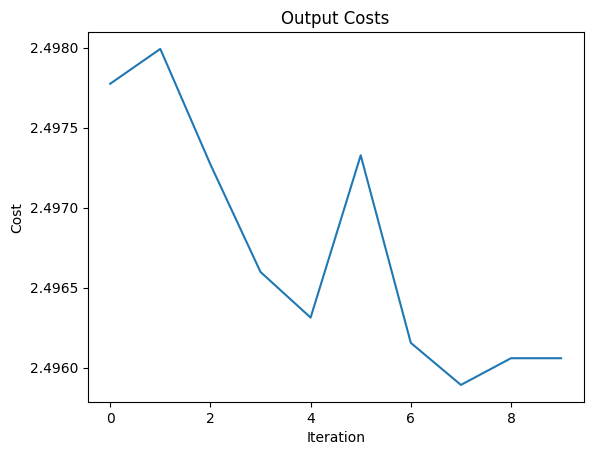

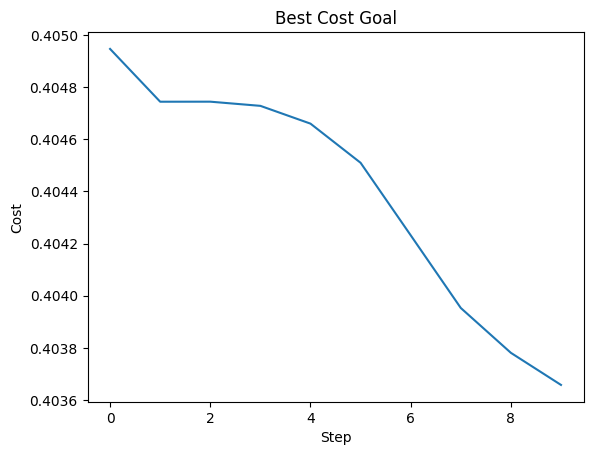

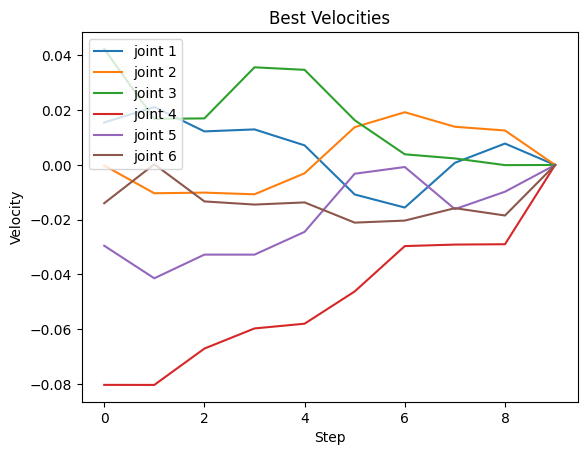

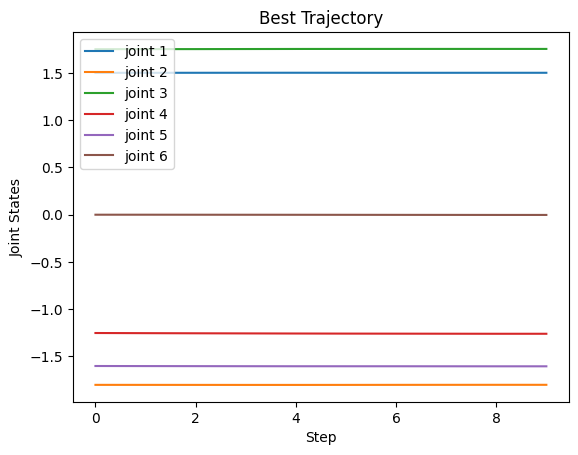

In [18]:

plt.figure(0)
plt.plot(cost)
plt.title("Output Costs")
plt.xlabel("Iteration")
plt.ylabel("Cost")
plt.show()

plt.figure(0)
plt.plot(best_cost_g)
plt.title("Best Cost Goal")
plt.xlabel("Step")
plt.ylabel("Cost")
plt.show()

plt.figure(0)
plt.plot(best_vels)
plt.title("Best Velocities")
plt.xlabel("Step")
plt.ylabel("Velocity")
plt.legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')
plt.show()

plt.figure(0)
plt.plot(best_traj)
plt.title("Best Trajectory")
plt.xlabel("Step")
plt.ylabel("Joint States")
plt.legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')
plt.show()


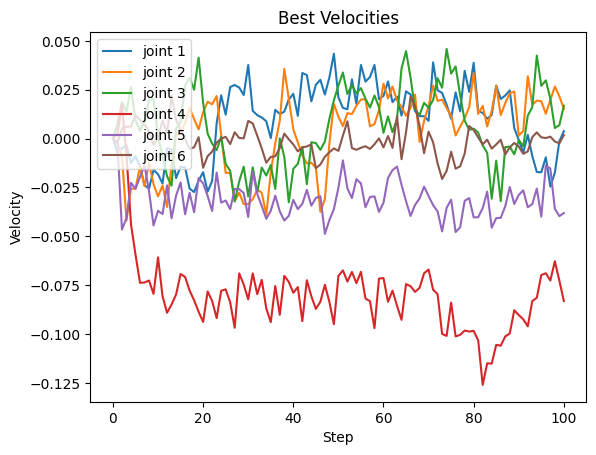

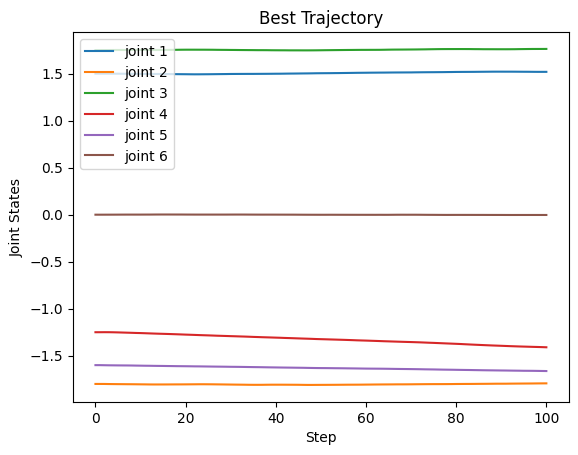

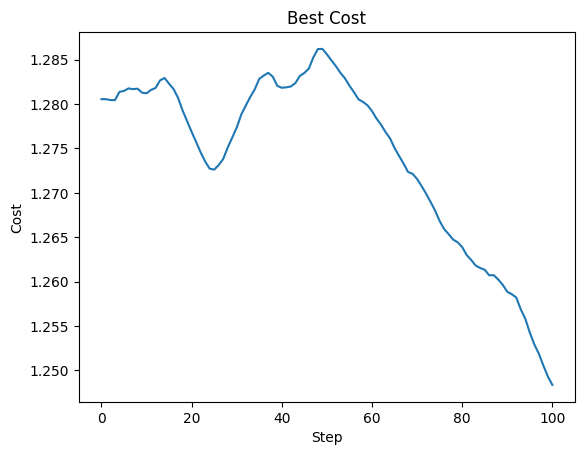

In [15]:
# step = 100
plt.figure(0)
plt.plot(thetadot_list)
plt.title("Best Velocities")
plt.xlabel("Step")
plt.ylabel("Velocity")
plt.legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')
plt.show()

plt.figure(1)
plt.plot(theta_list)
plt.title("Best Trajectory")
plt.xlabel("Step")
plt.ylabel("Joint States")
plt.legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')
plt.show()

plt.figure(2)
plt.plot(costs)
plt.title("Best Cost")
plt.xlabel("Step")
plt.ylabel("Cost")
plt.show()

# plt.figure(3)
# plt.plot(accs)
# plt.title("Acc")
# plt.xlabel("Step")
# plt.ylabel("Acc")
# plt.legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')
# plt.show()


In [ ]:
np.savetxt('data/best_traj.csv',theta_list, delimiter=",")
np.savetxt('data/best_vels.csv',thetadot_list, delimiter=",")

In [ ]:
pos = list()
vel = list()
costs = list()

model = cem.model
data = cem.data

pos.append(data.qpos[:6])
vel.append(data.qvel[:6])
# costs.append(np.linalg.norm(data.xpos[cem.hande_id] - cem.target_pos))

# qvel = cem.compute_cem(cem.mjx_data.qpos[:6], cem.mjx_data.qvel[:6])
rec = [0]*6

start = time.time()
for step in range(mpc_steps-1):
    step_start = time.time()

    rec = cem.compute_cem(data.qpos[:6], rec)

    data.qvel[:6] = rec

    mujoco.mj_step(model, data)

    # eef_pos = cem.mjx_data.xpos[cem.hande_id]
    # cost = np.linalg.norm(eef_pos - cem.target_pos)
    pos.append(data.qpos[:num_dof])
    vel.append(rec)
    # costs.append(cost)


In [ ]:
theta_init = np.tile([1.5, -1.8, 1.75, -1.25, -1.6, 0], (num_batch, 1))
# thetadot_init = np.zeros((num_batch, num_dof  ))
thetadot_init = np.tile(vel[3], (num_batch, 1))
thetaddot_init = np.zeros((num_batch, num_dof  ))
thetadot_fin = np.zeros((num_batch, num_dof  ))
thetaddot_fin = np.zeros((num_batch, num_dof  ))

state_term = np.hstack(( theta_init, thetadot_init, thetaddot_init, thetadot_fin, thetaddot_fin   ))
state_term = jnp.asarray(state_term)

maxiter_projection = 20
v_max = 0.8
a_max = 1.8
p_max = 180*np.pi/180

xi_mean = jnp.zeros(cem.nvar)
xi_cov = 5*jnp.identity(cem.nvar)

key, subkey = jax.random.split(cem.key)

xi_samples, key = cem.compute_xi_samples(key, xi_mean, xi_cov ) # xi_samples are matrix of batch times (cem.num_dof*cem.nvar_single = cem.nvar)
xi_filtered = cem.compute_projection_filter(xi_samples, state_term, maxiter_projection, v_max, a_max, p_max)
theta_batch = jnp.dot(cem.A_theta, xi_filtered.T).T 
thetadot = jnp.dot(cem.A_thetadot, xi_filtered.T).T

In [ ]:
thetadot_ = thetadot.reshape(thetadot.shape[0], num_dof, thetadot.shape[1]//num_dof)


In [ ]:
for t in thetadot_:
    plt.plot(t.T)
plt.title("Best Velocities")
plt.xlabel("Step")
plt.ylabel("Velocity")
plt.legend(['joint 1', 'joint 2', 'joint 3', 'joint 4', 'joint 5', 'joint 6'], loc='upper left')
plt.show()